<a href="https://colab.research.google.com/github/Nikhil199727/RFM-model/blob/main/RFM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet


In [ ]:
df_RFM = pd.read_csv('online_retail.csv')

In [ ]:
df_RFM.head( )

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df_RFM.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df_RFM = df_RFM.dropna(subset=['CustomerID'])
df_RFM = df_RFM.dropna(subset=['Description'])
df_RFM['Description'] = df_RFM['Description'].fillna('Unknown')
df_RFM.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df_RFM.duplicated().sum()

5225

In [ ]:
df_RFM = df_RFM.dropna(subset=['Description'])
df_RFM = df_RFM.drop_duplicates()

print(f"Number of duplicate rows after removal: {df_RFM.duplicated().sum()}")

Number of duplicate rows after removal: 0


In [ ]:
df_RFM = df_RFM.drop_duplicates(subset=['InvoiceNo', 'StockCode', 'CustomerID'])

print(f"Number of duplicate rows after removal: {df_RFM.duplicated().sum()}")
df_RFM = df_RFM.groupby(['InvoiceNo', 'StockCode', 'CustomerID']).agg({
    'Description': 'first',  # Keep the first occurrence of Description
    'Quantity': 'sum',
    'UnitPrice': 'sum',
    'InvoiceDate': 'first',  # Keep the first occurrence of InvoiceDate
    'Country': 'first'       # Keep the first occurrence of Country
}).reset_index()

Number of duplicate rows after removal: 0


In [ ]:
print(f"Number of duplicate rows remaining: {df_RFM.duplicated().sum()}")

Number of duplicate rows remaining: 0


In [ ]:
df_RFM.duplicated().sum()

0

In [ ]:
df_RFM['InvoiceDate'] = pd.to_datetime(df_RFM['InvoiceDate'])
df_RFM = df_RFM.dropna(subset=['CustomerID'])



In [ ]:
reference_date = df_RFM['InvoiceDate'].max()

df_RFM['Recency'] = (reference_date - df_RFM['InvoiceDate']).dt.days

recency_df = df_RFM.groupby('CustomerID').agg({'Recency': 'min'}).reset_index()

In [ ]:
frequency_df = df_RFM.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

In [ ]:
df_RFM['Monetary'] = df_RFM['Quantity'] * df_RFM['UnitPrice']
monetary_df = df_RFM.groupby('CustomerID').agg({'Monetary': 'sum'}).reset_index()

In [ ]:
rfm_df = pd.merge(recency_df, frequency_df, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')

print(rfm_df.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          2      0.00
1     12347.0        1          7   4310.00
2     12348.0       74          4   1595.64
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


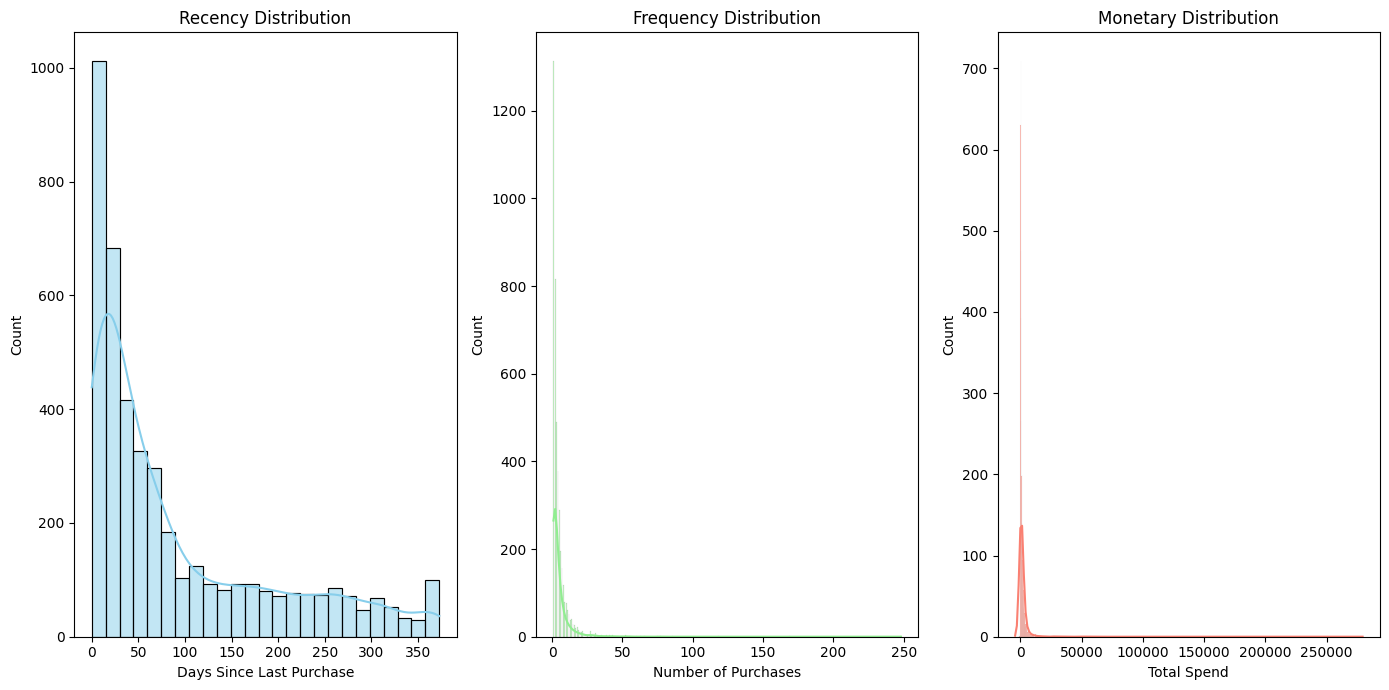

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')


plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True, color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')


plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], kde=True, color='salmon')
plt.title('Monetary Distribution')
plt.xlabel('Total Spend')

plt.tight_layout()
plt.show()